# Statistical analysis
In this notebook, we do statistical analysis of the results

In [2]:
import os
import json
import math
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# From huggingface api, with our trained adapters (eu, sr)
existing_adapters = [
    "th",
    "my",
    "hi",
    "ilo",
    "ht",
    "tr",
    "mi",
    "vi",
    "is",
    "it",
    "ta",
    "jv",
    "ja",
    "sw",
    "qu",
    "de",
    "el",
    "et",
    "ru",
    "gn",
    "id",
    "en",
    "ar",
    "es",
    "tk",
    "zh",
    "mhr",
    "cdo",
    "xmf",
    "eu",
    "sr",
]
# scraped from cc-100 website
xlm_included_langs = [
    "af",
    "am",
    "ar",
    "as",
    "az",
    "be",
    "bg",
    "bn",
    "br",
    "bs",
    "ca",
    "cs",
    "cy",
    "da",
    "de",
    "el",
    "en",
    "eo",
    "es",
    "et",
    "eu",
    "fa",
    "ff",
    "fi",
    "fr",
    "fy",
    "ga",
    "gd",
    "gl",
    "gn",
    "gu",
    "ha",
    "he",
    "hi",
    "hr",
    "ht",
    "hu",
    "hy",
    "id",
    "ig",
    "is",
    "it",
    "ja",
    "jv",
    "ka",
    "kk",
    "km",
    "kn",
    "ko",
    "ku",
    "ky",
    "la",
    "lg",
    "li",
    "ln",
    "lo",
    "lt",
    "lv",
    "mg",
    "mk",
    "ml",
    "mn",
    "mr",
    "ms",
    "my",
    "ne",
    "nl",
    "no",
    "ns",
    "om",
    "or",
    "pa",
    "pl",
    "ps",
    "pt",
    "qu",
    "rm",
    "ro",
    "ru",
    "sa",
    "si",
    "sc",
    "sd",
    "sk",
    "sl",
    "so",
    "sq",
    "sr",
    "ss",
    "su",
    "sv",
    "sw",
    "ta",
    "te",
    "th",
    "tl",
    "tn",
    "tr",
    "ug",
    "uk",
    "ur",
    "uz",
    "vi",
    "wo",
    "xh",
    "yi",
    "yo",
    "zu",
    "zh",
]

In [3]:
scores = {"ner": {}, "pos": {}, "copa": {}, "qa": {}}
tasks = scores.keys()
f1 = {"ner": "eval_f1", "copa": "eval_acc", "pos": "eval_f1_macro", "qa": "f1"}
inf = math.inf
for file in os.listdir("../eval_scores/selected"):
    if file.endswith(".json"):
        try:
            with open(os.path.join("../eval_scores/selected", file), "r") as f:
                data = json.load(f)
                task_name = file.split(".")[0]

                scores[task_name] = data

        except json.JSONDecodeError:
            print(f"Error decoding JSON for file: {file}")
        except KeyError:
            print("KeyError:", file)
langs = set()
for task in tasks:
    for lang_name in scores[task]:
        if "reconstructed_featural" not in scores[task][lang_name].keys():
            continue
        langs.add(lang_name)
# we remove all languages from score that are not in langs
for task_name in scores:
    for lang_name in list(scores[task_name].keys()):
        if lang_name not in langs:
            del scores[task_name][lang_name]
# we make a subset consisting of only the languages for which an adapter exists
with_adapter = {}
no_adapter = {}
for task_name in scores:
    with_adapter[task_name] = {}
    no_adapter[task_name] = {}
    for lang_name in scores[task_name]:
        if lang_name not in langs:
            continue
        if lang_name in existing_adapters:
            with_adapter[task_name][lang_name] = scores[task_name][lang_name]
        else:
            no_adapter[task_name][lang_name] = scores[task_name][lang_name]

xlm_included = {}
xlm_not_included = {}
for task_name in scores:
    xlm_included[task_name] = {}
    xlm_not_included[task_name] = {}
    for lang_name in scores[task_name]:
        if lang_name in xlm_included_langs:
            xlm_included[task_name][lang_name] = scores[task_name][lang_name]
        else:
            xlm_not_included[task_name][lang_name] = scores[task_name][lang_name]
token_overlap = {}
for file in os.listdir("../data/token_overlap"):
    if file.endswith(".json"):
        try:
            with open(os.path.join("../data/token_overlap", file), "r") as f:
                data = json.load(f)
                task_name = file.split("_")[0]
                token_overlap[task_name] = data
        except json.JSONDecodeError:
            print(f"Error decoding JSON for file: {file}")
        except KeyError:
            print("KeyError:", file)


print("total languages:", len(langs))
for task in tasks:
    print(f"task: {task}, {len(set(scores[task]).intersection(langs))} languages")
    print(
        f"{len(set(with_adapter[task]).intersection(langs))} have a trained language adapter, {len(set(no_adapter[task]).intersection(langs))} not"
    )
    print(
        f"{len(set(xlm_included[task]).intersection(langs))} are in the xlm included languages, {len(set(xlm_not_included[task]).intersection(langs))} not"
    )
    # we make a list of all languages

total languages: 157
task: ner, 134 languages
29 have a trained language adapter, 105 not
85 are in the xlm included languages, 49 not
task: pos, 80 languages
19 have a trained language adapter, 61 not
57 are in the xlm included languages, 23 not
task: copa, 11 languages
11 have a trained language adapter, 0 not
11 are in the xlm included languages, 0 not
task: qa, 12 languages
11 have a trained language adapter, 1 not
12 are in the xlm included languages, 0 not


In [4]:
def get_significance(task_name, option1, option2, alternative="two-sided", data=scores):
    all_scores1 = []
    all_scores2 = []
    if task_name == "all":
        task_names = data.keys()
    elif type(task_name) is str:
        task_names = [task_name]
    else:
        task_names = task_name
    for task_name in task_names:
        for lang_name in data[task_name]:
            if option1 in data[task_name][lang_name] and option2 in data[task_name][lang_name]:
                score1 = data[task_name][lang_name][option1]
                score2 = data[task_name][lang_name][option2]
                all_scores1.append(score1)
                all_scores2.append(score2)
    print("average scores")
    print(f"{option1}: {np.mean(all_scores1)}")
    print(f"{option2}: {np.mean(all_scores2)}")
    t_stat, p_val = stats.ttest_rel(all_scores1, all_scores2, alternative=alternative)
    print(f"t-statistic: {t_stat}")
    print(f"p-value: {p_val}")
    return t_stat, p_val

# 1. Overall scores
We take together all tasks, and check if our method is better than the baselines.
This gives more weight to NER, followed by POS, and much less to QA and COPA as they have less overall datapoints to consider.
--> We will present an analysis per task later on.

In [5]:
test_column = "reconstructed_featural"
baselines = ["finetune", "baseline_en", "baseline_avg_adapter", "baseline_closest_featural", "no_train_gain"]

sign = []
not_sign = []
for baseline in baselines:
    print(f"ALL tasks, baseline {baseline}")
    t_stat, p_val = get_significance("all", test_column, baseline, alternative="greater")
    if p_val < 0.05:
        print("The difference is statistically significant")
        sign.append("all" + "_" + baseline)
    else:
        print("The difference is not statistically significant")
        not_sign.append("all" + "_" + baseline)
    print("-----------------------------------")

print("sign", sign)
print("\nnotsign", not_sign)

ALL tasks, baseline finetune
average scores
reconstructed_featural: 0.5037595015953552
finetune: 0.40938583417890956
t-statistic: 18.204190876572856
p-value: 4.35686322326579e-47
The difference is statistically significant
-----------------------------------
ALL tasks, baseline baseline_en
average scores
reconstructed_featural: 0.5037595015953552
baseline_en: 0.47759895656811724
t-statistic: 7.334378494621557
p-value: 1.7934821769898803e-12
The difference is statistically significant
-----------------------------------
ALL tasks, baseline baseline_avg_adapter
average scores
reconstructed_featural: 0.5037595015953552
baseline_avg_adapter: 0.43721141279941217
t-statistic: 15.577858201981066
p-value: 2.3077390135264786e-38
The difference is statistically significant
-----------------------------------
ALL tasks, baseline baseline_closest_featural
average scores
reconstructed_featural: 0.5037595015953552
baseline_closest_featural: 0.4584915738793187
t-statistic: 7.757918804154872
p-value: 

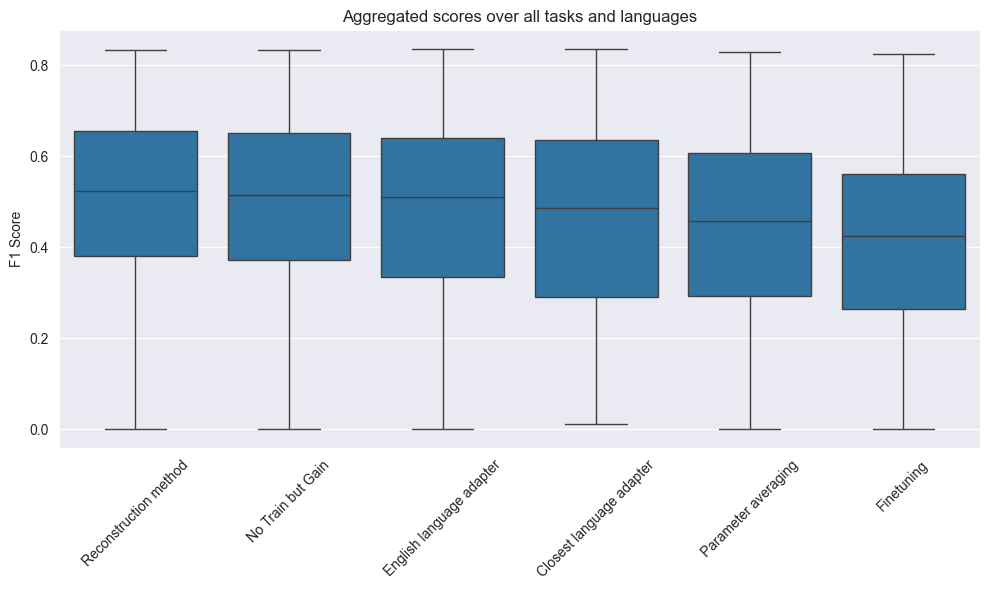

In [8]:
# we make a boxplot of the scores
def make_boxplot(tasks, columns):
    data = []
    if tasks == "all":
        task_names = scores.keys()
    elif len(tasks) == 1:
        task_names = [tasks]
    else:
        task_names = tasks
    for task in task_names:
        for lang_name in scores[task]:
            if all(col in scores[task][lang_name] for col in columns):
                data.append([task, lang_name] + [scores[task][lang_name][col] for col in columns])
    df = pd.DataFrame(data, columns=["task", "lang_name"] + columns)
    # we melt the dataframe to get it in the right format for seaborn
    df_melted = df.melt(id_vars=["task", "lang_name"], value_vars=columns, var_name="method", value_name="score")
    # we plot the data
    plt.figure(figsize=(10, 6))
    sns.boxplot(x="method", y="score", data=df_melted)
    plt.title(f"Comparison of methods for {tasks}")
    plt.xlabel("Method")
    plt.ylabel("Score")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


plot_data = []
for task in tasks:
    for lang_name in scores[task]:
        if all(
            col in scores[task][lang_name]
            for col in [
                "reconstructed_featural",
                "no_train_gain",
                "baseline_en",
                "baseline_closest_featural",
                "baseline_avg_adapter",
                "finetune",
            ]
        ):
            plot_data.append(
                [task, lang_name]
                + [
                    scores[task][lang_name][col]
                    for col in [
                        "reconstructed_featural",
                        "no_train_gain",
                        "baseline_en",
                        "baseline_closest_featural",
                        "baseline_avg_adapter",
                        "finetune",
                    ]
                ]
            )
df_plot = pd.DataFrame(
    plot_data,
    columns=[
        "task",
        "lang_name",
        "reconstructed_featural",
        "no_train_gain",
        "baseline_en",
        "baseline_closest_featural",
        "baseline_avg_adapter",
        "finetune",
    ],
)
df_melted = df_plot.melt(
    id_vars=["task", "lang_name"],
    value_vars=[
        "reconstructed_featural",
        "no_train_gain",
        "baseline_en",
        "baseline_closest_featural",
        "baseline_avg_adapter",
        "finetune",
    ],
    var_name="method",
    value_name="score",
)
# we rename the methods
table_scores = {
    "reconstructed_featural": "Reconstruction method",
    "no_train_gain": "No Train but Gain",
    "baseline_en": "English language adapter",
    "baseline_closest_featural": "Closest language adapter",
    "baseline_avg_adapter": "Parameter averaging",
    "finetune": "Finetuning",
}
df_melted["method"] = df_melted["method"].map(table_scores)
plt.figure(figsize=(10, 6))
sns.boxplot(x="method", y="score", data=df_melted)
plt.title("Aggregated scores over all tasks and languages")
# plt.xlabel("Method")
# we remove x label
plt.xlabel("")
plt.ylabel("F1 Score")
plt.xticks(rotation=45)
plt.tight_layout()
# we save as pdf
plt.savefig("../output/aggregated_all_tasks.pdf", dpi=1000)

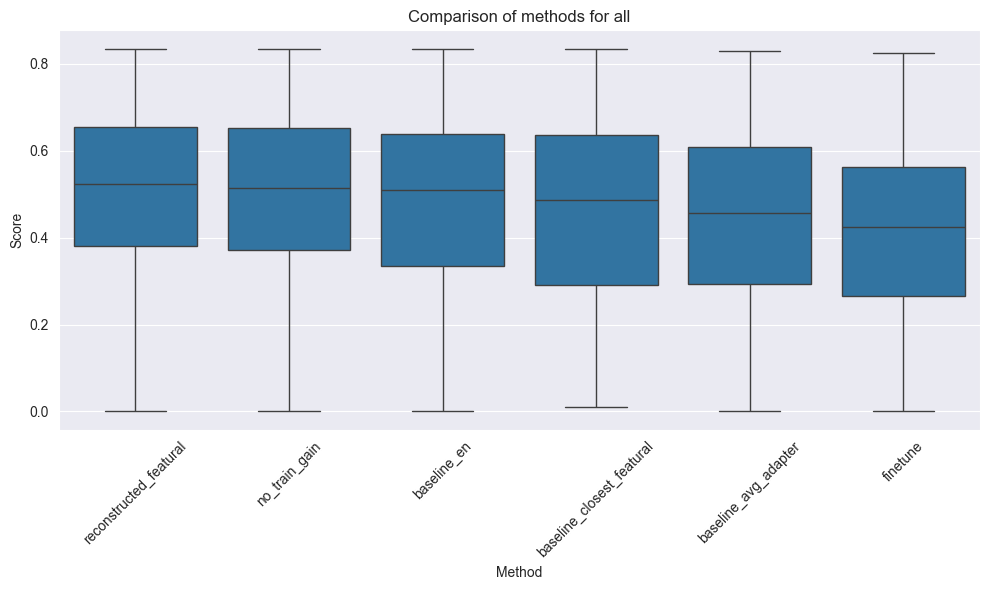

In [7]:
make_boxplot(
    "all",
    [
        "reconstructed_featural",
        "no_train_gain",
        "baseline_en",
        "baseline_closest_featural",
        "baseline_avg_adapter",
        "finetune",
    ],
)

# 2. Task-specific scores
Per task, we look how the method compares to the baselines.

In [7]:
tasks = ["ner", "pos", "copa", "qa"]
test_column = "reconstructed_featural"
baselines = ["finetune", "baseline_en", "baseline_avg_adapter", "baseline_closest_featural", "no_train_gain"]

sign = []
not_sign = []

for task in tasks:
    for baseline in baselines:
        print(f"task: {task}, baseline {baseline}")
        t_stat, p_val = get_significance(task, test_column, baseline, alternative="greater")
        if p_val < 0.05:
            print("The difference is statistically significant")
            sign.append(task + "_" + baseline)
        else:
            print("The difference is not statistically significant")
            not_sign.append(task + "_" + baseline)
        print("-----------------------------------")

print("sign", sign)
print("\nnotsign", not_sign)

task: ner, baseline finetune
average scores
reconstructed_featural: 0.5013399275268126
finetune: 0.3915923233860745
t-statistic: 16.291464164268035
p-value: 1.081066709663728e-33
The difference is statistically significant
-----------------------------------
task: ner, baseline baseline_en
average scores
reconstructed_featural: 0.5013399275268126
baseline_en: 0.45986180313931335
t-statistic: 7.159465234751556
p-value: 2.536303577786147e-11
The difference is statistically significant
-----------------------------------
task: ner, baseline baseline_avg_adapter
average scores
reconstructed_featural: 0.5013399275268126
baseline_avg_adapter: 0.39532461426531496
t-statistic: 20.254865386795764
p-value: 1.2575944653491345e-42
The difference is statistically significant
-----------------------------------
task: ner, baseline baseline_closest_featural
average scores
reconstructed_featural: 0.5013399275268126
baseline_closest_featural: 0.4334773294245811
t-statistic: 7.184401396341495
p-value: 2

In [8]:
tasks = ["pos"]
test_column = "reconstructed_featural"
baselines = ["no_train_gain"]

sign = []
not_sign = []

for task in tasks:
    for baseline in baselines:
        print(f"task: {task}, baseline {baseline}")
        t_stat, p_val = get_significance(task, test_column, baseline, alternative="two-sided")
        if p_val < 0.05:
            print("The difference is statistically significant")
            sign.append(task + "_" + baseline)
        else:
            print("The difference is not statistically significant")
            not_sign.append(task + "_" + baseline)
        print("-----------------------------------")

print("sign", sign)
print("\nnotsign", not_sign)

task: pos, baseline no_train_gain
average scores
reconstructed_featural: 0.4679441087506307
no_train_gain: 0.4685519779311475
t-statistic: -0.4049515629735013
p-value: 0.686607571400405
The difference is not statistically significant
-----------------------------------
sign []

notsign ['pos_no_train_gain']


In [9]:
tasks = ["copa"]
test_column = "reconstructed_featural"
baselines = ["finetune", "baseline_closest_featural", "baseline_en"]

sign = []
not_sign = []

for task in tasks:
    for baseline in baselines:
        print(f"task: {task}, baseline {baseline}")
        t_stat, p_val = get_significance(task, test_column, baseline, alternative="greater")
        if p_val < 0.05:
            print("The difference is statistically significant")
            sign.append(task + "_" + baseline)
        else:
            print("The difference is not statistically significant")
            not_sign.append(task + "_" + baseline)
        print("-----------------------------------")

print("sign", sign)
print("\nnotsign", not_sign)

task: copa, baseline finetune
average scores
reconstructed_featural: 0.5498181818181818
finetune: 0.5552727272727273
t-statistic: -0.7693825361789232
p-value: 0.7702733142031852
The difference is not statistically significant
-----------------------------------
task: copa, baseline baseline_closest_featural
average scores
reconstructed_featural: 0.5498181818181818
baseline_closest_featural: 0.5645454545454546
t-statistic: -1.699716349014447
p-value: 0.9399880024842558
The difference is not statistically significant
-----------------------------------
task: copa, baseline baseline_en
average scores
reconstructed_featural: 0.5498181818181818
baseline_en: 0.532909090909091
t-statistic: 3.0259307025372006
p-value: 0.006382762458236786
The difference is statistically significant
-----------------------------------
sign ['copa_baseline_en']

notsign ['copa_finetune', 'copa_baseline_closest_featural']


# Analysis
We check the scores for different subsets of the data

In [10]:
task = "ner"
test_column = "reconstructed_featural"
baseline = "baseline_closest_featural"
alternatives = ["greater", "less"]
subsets = {"with adapter": with_adapter, "no adapter": no_adapter}

sign = []
not_sign = []

for subset_name, subset in subsets.items():
    print(
        f"task: {task}, evaluating on languages not included in XLM training ({len(xlm_not_included[task])}/{len(scores[task])} languages)"
    )
    for alternative in alternatives:
        print(f"task: {task}, baseline {baseline}, checking if {alternative} in {subset_name}")
        t_stat, p_val = get_significance(task, test_column, baseline, alternative=alternative, data=subset)
        if p_val < 0.05:
            print("The difference is statistically significant")
            sign.append(task + "_" + baseline)
        else:
            print("The difference is not statistically significant")
            not_sign.append(task + "_" + baseline)
        print("-----------------------------------")

print("sign", sign)
print("\nnotsign", not_sign)

task: ner, evaluating on languages not included in XLM training (49/134 languages)
task: ner, baseline baseline_closest_featural, checking if greater in with adapter
average scores
reconstructed_featural: 0.4874836773042384
baseline_closest_featural: 0.5048611993386083
t-statistic: -1.8048238679665487
p-value: 0.959065812755424
The difference is not statistically significant
-----------------------------------
task: ner, baseline baseline_closest_featural, checking if less in with adapter
average scores
reconstructed_featural: 0.4874836773042384
baseline_closest_featural: 0.5048611993386083
t-statistic: -1.8048238679665487
p-value: 0.04093418724457597
The difference is statistically significant
-----------------------------------
task: ner, evaluating on languages not included in XLM training (49/134 languages)
task: ner, baseline baseline_closest_featural, checking if greater in no adapter
average scores
reconstructed_featural: 0.5052036896081072
baseline_closest_featural: 0.413572211

In [11]:
tasks = ["ner", "pos"]
test_column = "reconstructed_featural"
baselines = ["finetune", "baseline_en", "baseline_avg_adapter", "baseline_closest_featural", "no_train_gain"]

sign = []
not_sign = []

for task in tasks:
    print(
        f"task: {task}, evaluating on languages not included in XLM training ({len(xlm_not_included[task])}/{len(scores[task])} languages)"
    )
    for baseline in baselines:
        print(f"task: {task}, baseline {baseline}")
        t_stat, p_val = get_significance(task, test_column, baseline, alternative="greater", data=xlm_not_included)
        if p_val < 0.05:
            print("The difference is statistically significant")
            sign.append(task + "_" + baseline)
        else:
            print("The difference is not statistically significant")
            not_sign.append(task + "_" + baseline)
        print("-----------------------------------")

print("sign", sign)
print("\nnotsign", not_sign)

task: ner, evaluating on languages not included in XLM training (49/134 languages)
task: ner, baseline finetune
average scores
reconstructed_featural: 0.411980159522687
finetune: 0.3216134361593413
t-statistic: 7.957403975618941
p-value: 1.4745187154038504e-10
The difference is statistically significant
-----------------------------------
task: ner, baseline baseline_en
average scores
reconstructed_featural: 0.411980159522687
baseline_en: 0.38306960466957785
t-statistic: 3.067429424574741
p-value: 0.0017881211054052843
The difference is statistically significant
-----------------------------------
task: ner, baseline baseline_avg_adapter
average scores
reconstructed_featural: 0.411980159522687
baseline_avg_adapter: 0.3120115016104649
t-statistic: 9.950011418520425
p-value: 1.8819605261853367e-13
The difference is statistically significant
-----------------------------------
task: ner, baseline baseline_closest_featural
average scores
reconstructed_featural: 0.411980159522687
baseline_c

# Multivariate analysis
We will check if inclusion in XLM training, or adapter availability have an effect on the scores.
Also, it is interesting to map this not to the absolute score, but to the difference our method can make relative to the baselines.

In [12]:
# we start by preparing a dataframe: language, scores (& baselines), true/false labels for xlm inclusion and for adapter availability
tasks = ["ner", "pos", "copa", "qa"]
scores_inclusion = [
    "reconstructed_featural",
    "finetune",
    "baseline_en",
    "baseline_task_adapter",
    "baseline_closest_featural",
    "no_train_gain",
]
data = []
for task in tasks:
    for lang_name in scores[task]:
        if all(col in scores[task][lang_name] for col in scores_inclusion):
            data.append([task, lang_name] + [scores[task][lang_name][col] for col in scores_inclusion])
df = pd.DataFrame(data, columns=["task", "lang_name"] + scores_inclusion)
# we add a column for xlm inclusion and adaper availability
df["xlm_inclusion"] = df["lang_name"].apply(lambda x: 1 if x in xlm_included_langs else 0)
df["adapter_availability"] = df["lang_name"].apply(lambda x: 1 if x in existing_adapters else 0)
df["overall_average"] = df[scores_inclusion].mean(axis=1)
df["overall_average_exclude"] = df[scores_inclusion].drop(columns=["reconstructed_featural"]).mean(axis=1)
df["overall_improvement"] = df["reconstructed_featural"] - df["overall_average_exclude"]
df["madx_improvement"] = df["reconstructed_featural"] - df["baseline_closest_featural"]
df["train_gain_improvement"] = df["reconstructed_featural"] - df["no_train_gain"]
df["finetune_improvement"] = df["reconstructed_featural"] - df["finetune"]
df["baseline_en_improvement"] = df["reconstructed_featural"] - df["baseline_en"]
df["task_adapter_improvement"] = df["reconstructed_featural"] - df["baseline_task_adapter"]

We have also calculated distance to english in another notebook (unseen_eval_analysis.ipynb)

In [13]:
import pickle

with open("../pickles/typ_dists.pkl", "rb") as f:
    typ_dists = pickle.load(f)

# we add this to df, making a copy of only the rows that have info in typ_dists
df["distance"] = df["lang_name"].apply(lambda x: typ_dists[x])

In [14]:
# we add token overlap scores
for task in tasks:
    for lang_name in scores[task]:
        if task in token_overlap and lang_name in token_overlap[task]:
            df.loc[(df["task"] == task) & (df["lang_name"] == lang_name), "token_overlap"] = float(
                token_overlap[task][lang_name]["token_coverage"]
            )
df["token_overlap"] = pd.to_numeric(df["token_overlap"], errors="raise")

In [15]:
from sklearn import linear_model

regr = linear_model.LinearRegression()
X = df[["xlm_inclusion", "adapter_availability"]]
y = df["baseline_closest_featural"]  ## we test this with featural_reconstructed, and with the mad-x scores
regr.fit(X, y)
# we interpret this:
# - xlm_inclusion: 1 means the language was included in the xlm training, 0 means it was not
# - adapter_availability: 1 means the language has a trained adapter, 0 means it does not
# - reconstructed_featural: the score of the language with our method

# we can check the coefficients of the linear regression
print("Coefficients: ", regr.coef_)
print("Intercept: ", regr.intercept_)
# we can check the r^2 score of the linear regression
print("R^2 score: ", regr.score(X, y))
# we can check the p-values of the coefficients
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

Coefficients:  [0.16417714 0.09491956]
Intercept:  0.31555260094976445
R^2 score:  0.21590058560381964
                                OLS Regression Results                               
Dep. Variable:     baseline_closest_featural   R-squared:                       0.216
Model:                                   OLS   Adj. R-squared:                  0.209
Method:                        Least Squares   F-statistic:                     32.08
Date:                       Thu, 29 May 2025   Prob (F-statistic):           4.95e-13
Time:                               12:00:34   Log-Likelihood:                 60.313
No. Observations:                        236   AIC:                            -114.6
Df Residuals:                            233   BIC:                            -104.2
Df Model:                                  2                                         
Covariance Type:                   nonrobust                                         
                           coef    st

## interpretation:
XLM inclusion is crucial to the scores in general, adapter inclusion is not.
!! ALL adapter inclusion models are ALSO included in XLM-R
For MAD-X (closest_featural baseline), as we had expected, adapter availability plays a much larger role.

In [16]:
# we now map the average of all scores, compared to these coefficients
regr = linear_model.LinearRegression()
X = df[["xlm_inclusion", "adapter_availability"]]
y = df["overall_average_exclude"]
regr.fit(X, y)
# we interpret this:
# - xlm_inclusion: 1 means the language was included in the xlm training, 0 means it was not
# - adapter_availability: 1 means the language has a trained adapter, 0 means it does not
# - reconstructed_featural: the score of the language with our method

# we can check the coefficients of the linear regression
print("Coefficients: ", regr.coef_)
print("Intercept: ", regr.intercept_)
# we can check the r^2 score of the linear regression
print("R^2 score: ", regr.score(X, y))
# we can check the p-values of the coefficients

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

Coefficients:  [0.19015548 0.03178857]
Intercept:  0.3206391909805296
R^2 score:  0.23561262565606977
                               OLS Regression Results                              
Dep. Variable:     overall_average_exclude   R-squared:                       0.236
Model:                                 OLS   Adj. R-squared:                  0.229
Method:                      Least Squares   F-statistic:                     35.91
Date:                     Thu, 29 May 2025   Prob (F-statistic):           2.55e-14
Time:                             12:00:34   Log-Likelihood:                 86.929
No. Observations:                      236   AIC:                            -167.9
Df Residuals:                          233   BIC:                            -157.5
Df Model:                                2                                         
Covariance Type:                 nonrobust                                         
                           coef    std err          t     

In [17]:
# we now map the average of all scores, compared to these coefficients
X = df[["xlm_inclusion", "adapter_availability"]]
y = df["overall_improvement"]
regr.fit(X, y)
# we interpret this:
# - xlm_inclusion: 1 means the language was included in the xlm training, 0 means it was not
# - adapter_availability: 1 means the language has a trained adapter, 0 means it does not
# - reconstructed_featural: the score of the language with our method

# we can check the coefficients of the linear regression
print("Coefficients: ", regr.coef_)
print("Intercept: ", regr.intercept_)
# we can check the r^2 score of the linear regression
print("R^2 score: ", regr.score(X, y))
# we can check the p-values of the coefficients

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

Coefficients:  [ 0.02000563 -0.03065634]
Intercept:  0.035849804994200006
R^2 score:  0.10447835440267084
                             OLS Regression Results                            
Dep. Variable:     overall_improvement   R-squared:                       0.104
Model:                             OLS   Adj. R-squared:                  0.097
Method:                  Least Squares   F-statistic:                     13.59
Date:                 Thu, 29 May 2025   Prob (F-statistic):           2.61e-06
Time:                         12:00:34   Log-Likelihood:                 418.55
No. Observations:                  236   AIC:                            -831.1
Df Residuals:                      233   BIC:                            -820.7
Df Model:                            2                                         
Covariance Type:             nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
-----

In [18]:
# we now map the average of all scores, compared to these coefficients
X = df[["xlm_inclusion", "adapter_availability"]]
y = df["madx_improvement"]
regr.fit(X, y)
# we interpret this:
# - xlm_inclusion: 1 means the language was included in the xlm training, 0 means it was not
# - adapter_availability: 1 means the language has a trained adapter, 0 means it does not
# - reconstructed_featural: the score of the language with our method

# we can check the coefficients of the linear regression
print("Coefficients: ", regr.coef_)
print("Intercept: ", regr.intercept_)
# we can check the r^2 score of the linear regression
print("R^2 score: ", regr.score(X, y))
# we can check the p-values of the coefficients

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

Coefficients:  [ 0.04598397 -0.09378733]
Intercept:  0.04093639502496527
R^2 score:  0.21158757908290582
                            OLS Regression Results                            
Dep. Variable:       madx_improvement   R-squared:                       0.212
Model:                            OLS   Adj. R-squared:                  0.205
Method:                 Least Squares   F-statistic:                     31.27
Date:                Thu, 29 May 2025   Prob (F-statistic):           9.37e-13
Time:                        12:00:34   Log-Likelihood:                 262.91
No. Observations:                 236   AIC:                            -519.8
Df Residuals:                     233   BIC:                            -509.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------

## MAD-X vs our method
Interesting results!
Inclusion in XLM has a positive effect on our method compared to MAD-X, suggesting that we are better suited at "retrieving" the information from XLM training.
However, and more interestingly, our method performs LESS if a language adapter is available: this means that when MAD-X is available, the difference is smaller: in cases where no adapter is available, our method is improves upon the scores.
As this is the goal of our method, this is a good result.

# Token overlap
we now look at the impact of the token overlap scores

In [19]:
# 1) assemble predictors
df_exp = df.copy()
# we only look at NER
df_exp = df_exp[df_exp["task"] == "ner"]
X = df_exp[["token_overlap", "xlm_inclusion"]]
X = sm.add_constant(X)  # adds the intercept term

# 2) fit
model = sm.OLS(df_exp["reconstructed_featural"], X).fit()

# 3) inspect
print(model.summary())

                              OLS Regression Results                              
Dep. Variable:     reconstructed_featural   R-squared:                       0.327
Model:                                OLS   Adj. R-squared:                  0.317
Method:                     Least Squares   F-statistic:                     31.62
Date:                    Thu, 29 May 2025   Prob (F-statistic):           6.44e-12
Time:                            12:00:34   Log-Likelihood:                 64.847
No. Observations:                     133   AIC:                            -123.7
Df Residuals:                         130   BIC:                            -115.0
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const 

Both how much data overlaps at the token level and whether the language is included in XLM-R emerge as independent, meaningful predictors. 
Token‐overlap brings new explanatory power beyond the binary inclusion flag, boosting the explained variance from ~26% to ~36%.

In [20]:
# 1) assemble predictors
df_exp = df.copy()
# we only look at NER
df_exp = df_exp[df_exp["task"] == "pos"]
X = df_exp[["token_overlap", "adapter_availability"]]
X = sm.add_constant(X)  # adds the intercept term

# 2) fit
model = sm.OLS(df_exp["madx_improvement"], X).fit()

# 3) inspect
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       madx_improvement   R-squared:                       0.160
Model:                            OLS   Adj. R-squared:                  0.138
Method:                 Least Squares   F-statistic:                     7.339
Date:                Thu, 29 May 2025   Prob (F-statistic):            0.00121
Time:                        12:00:34   Log-Likelihood:                 146.50
No. Observations:                  80   AIC:                            -287.0
Df Residuals:                      77   BIC:                            -279.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0507 

High token overlap with english, makes for a smaller improvement over MAD-X, with higher impact than adapter availabilty (which also plays a role)
--> If the target language has no adapter, or if it is far from English, our method is a lot better than MAD-X

In [21]:
# 1) assemble predictors
X = df[["token_overlap", "xlm_inclusion"]]
X = sm.add_constant(X)  # adds the intercept term

# 2) fit
model = sm.OLS(df["finetune_improvement"], X).fit()

# 3) inspect
print(model.summary())

                             OLS Regression Results                             
Dep. Variable:     finetune_improvement   R-squared:                       0.045
Model:                              OLS   Adj. R-squared:                  0.037
Method:                   Least Squares   F-statistic:                     5.531
Date:                  Thu, 29 May 2025   Prob (F-statistic):            0.00450
Time:                          12:00:35   Log-Likelihood:                 268.24
No. Observations:                   236   AIC:                            -530.5
Df Residuals:                       233   BIC:                            -520.1
Df Model:                             2                                         
Covariance Type:              nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1084  

In [22]:
# we do this separately for NER and POS
for task in ["ner", "pos"]:
    df_exp = df.copy()
    # we only look at the task
    df_exp = df_exp[df_exp["task"] == task]
    X = df_exp[["token_overlap", "distance"]]
    X = sm.add_constant(X)  # adds the intercept term
    # 2) fit
    model = sm.OLS(df_exp["finetune_improvement"], X).fit()
    # 3) inspect
    print(f"Task: {task}")
    print(model.summary())

Task: ner
                             OLS Regression Results                             
Dep. Variable:     finetune_improvement   R-squared:                       0.140
Model:                              OLS   Adj. R-squared:                  0.127
Method:                   Least Squares   F-statistic:                     10.59
Date:                  Thu, 29 May 2025   Prob (F-statistic):           5.50e-05
Time:                          12:00:35   Log-Likelihood:                 161.64
No. Observations:                   133   AIC:                            -317.3
Df Residuals:                       130   BIC:                            -308.6
Df Model:                             2                                         
Covariance Type:              nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           

Interesting!
Improvement over finetune is larger, if there is a smaller token overlap (significant deterioration).
Inclusion in the original XLM training has no significant effect on the data. 

Quick GPT-powered analysis:

Baseline (intercept ≈ 0.1084)
For a language with zero token-overlap and not included in the XLM, the expected gain of the method over English fine-tuning is about 0.108.

Token-overlap (coef ≈ –0.0503, p = 0.021)
Each one-unit rise in token overlap is tied to a 0.05-point drop in relative improvement. In other words, languages whose data already align more closely (at the token level) with the training distribution gain slightly less from the approach compared with vanilla fine-tuning (t ≈ –2.33, p < .05).

XLM-inclusion (coef ≈ 0.0212, p = 0.062)
Having a language built into the XLM adds about 0.02 points of extra gain—though this effect just misses conventional significance (t ≈ 1.87, p ≈ .06). It’s suggestive of a small boost, but you can’t confidently rule out chance at α = .05.

Model fit (R² ≈ 0.045; F(2, 233) = 5.53, p ≈ .0045)
The two predictors together explain only about 4.5% of the variance in finetune-improvement. The overall F-test is significant, so there is a real signal here, but most of the variation still lies elsewhere.

## baseline_en score in function of distance to english
==> Keeping the en language adapter is significantly better for languages close to english
- this is not surprising!

                            OLS Regression Results                            
Dep. Variable:            baseline_en   R-squared:                       0.181
Model:                            OLS   Adj. R-squared:                  0.178
Method:                 Least Squares   F-statistic:                     51.86
Date:                Thu, 29 May 2025   Prob (F-statistic):           8.09e-12
Time:                        12:00:35   Log-Likelihood:                 68.614
No. Observations:                 236   AIC:                            -133.2
Df Residuals:                     234   BIC:                            -126.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9118      0.061     14.840      0.0

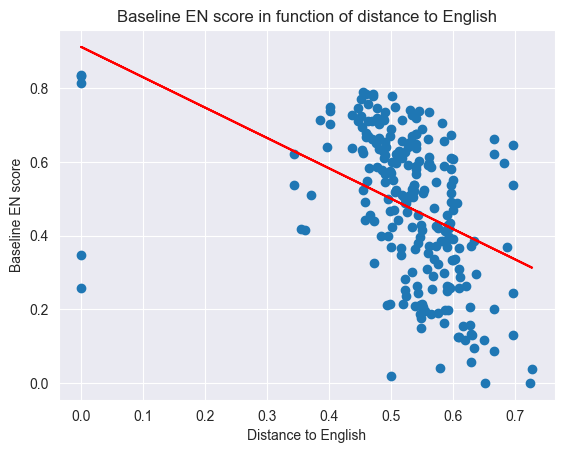

In [23]:
# we do simple regression. The distance is the independent variable, the score is the dependent variable

X = df[["distance"]]
X = sm.add_constant(X)  # adds the intercept term
y = df["baseline_en"]
model = sm.OLS(y, X).fit()
print(model.summary())
# we can plot the data
plt.scatter(df["distance"], df["baseline_en"])
plt.plot(df["distance"], model.predict(X), color="red")
plt.xlabel("Distance to English")
plt.ylabel("Baseline EN score")
plt.title("Baseline EN score in function of distance to English")
plt.show()

                              OLS Regression Results                              
Dep. Variable:     reconstructed_featural   R-squared:                       0.165
Model:                                OLS   Adj. R-squared:                  0.162
Method:                     Least Squares   F-statistic:                     46.31
Date:                    Thu, 29 May 2025   Prob (F-statistic):           8.38e-11
Time:                            12:00:35   Log-Likelihood:                 78.206
No. Observations:                     236   AIC:                            -152.4
Df Residuals:                         234   BIC:                            -145.5
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       

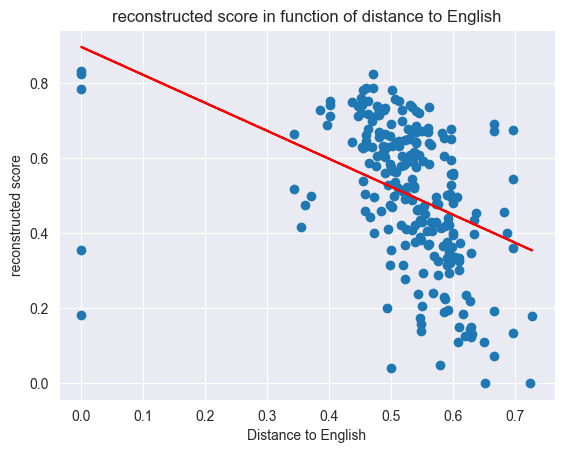

In [24]:
# we do simple regression. The distance is the independent variable, the score is the dependent variable

X = df[["distance"]]
X = sm.add_constant(X)  # adds the intercept term
y = df["reconstructed_featural"]
model = sm.OLS(y, X).fit()
print(model.summary())
# we can plot the data
plt.scatter(df["distance"], df["reconstructed_featural"])
plt.plot(df["distance"], model.predict(X), color="red")
plt.xlabel("Distance to English")
plt.ylabel("reconstructed score")
plt.title("reconstructed score in function of distance to English")
plt.show()

                              OLS Regression Results                             
Dep. Variable:     baseline_task_adapter   R-squared:                       0.171
Model:                               OLS   Adj. R-squared:                  0.168
Method:                    Least Squares   F-statistic:                     48.44
Date:                   Thu, 29 May 2025   Prob (F-statistic):           3.40e-11
Time:                           12:00:35   Log-Likelihood:                 73.026
No. Observations:                    236   AIC:                            -142.1
Df Residuals:                        234   BIC:                            -135.1
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8822 

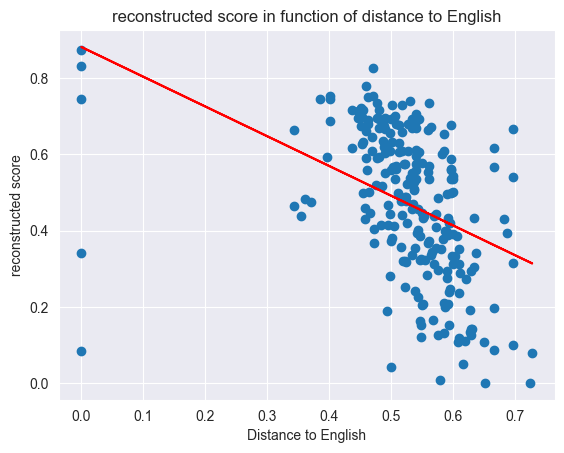

In [25]:
# we do simple regression. The distance is the independent variable, the score is the dependent variable

X = df[["distance"]]
X = sm.add_constant(X)  # adds the intercept term
y = df["baseline_task_adapter"]
model = sm.OLS(y, X).fit()
print(model.summary())
# we can plot the data
plt.scatter(df["distance"], df["baseline_task_adapter"])
plt.plot(df["distance"], model.predict(X), color="red")
plt.xlabel("Distance to English")
plt.ylabel("reconstructed score")
plt.title("reconstructed score in function of distance to English")
plt.show()

In [26]:
df_exp = df.copy()
# we only look at pos

X = df[["distance", "baseline_task_adapter"]]
X = sm.add_constant(X)  # adds the intercept term
y = df["reconstructed_featural"]
model = sm.OLS(y, X).fit()
print(model.summary())

                              OLS Regression Results                              
Dep. Variable:     reconstructed_featural   R-squared:                       0.951
Model:                                OLS   Adj. R-squared:                  0.951
Method:                     Least Squares   F-statistic:                     2283.
Date:                    Thu, 29 May 2025   Prob (F-statistic):          8.64e-154
Time:                            12:00:35   Log-Likelihood:                 413.88
No. Observations:                     236   AIC:                            -821.8
Df Residuals:                         233   BIC:                            -811.4
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

In [27]:
df_exp = df.copy()
# we only look at pos
df_exp = df_exp[df_exp["task"] == "ner"]
X = df_exp[["distance", "baseline_task_adapter", "baseline_en"]]
X = sm.add_constant(X)  # adds the intercept term
y = df_exp["reconstructed_featural"]
model = sm.OLS(y, X).fit()
print(model.summary())

                              OLS Regression Results                              
Dep. Variable:     reconstructed_featural   R-squared:                       0.956
Model:                                OLS   Adj. R-squared:                  0.955
Method:                     Least Squares   F-statistic:                     944.4
Date:                    Thu, 29 May 2025   Prob (F-statistic):           1.46e-87
Time:                            12:00:35   Log-Likelihood:                 246.89
No. Observations:                     133   AIC:                            -485.8
Df Residuals:                         129   BIC:                            -474.2
Df Model:                               3                                         
Covariance Type:                nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

# important results:
MOST of the variance in the score depends on how well the task adapter is suited for the language.
Our method's score highly correlates with this: two thirds of our reconstruction score is directly "baked in" by what the adapter alone can achieve.
Both baselines are correlated as well: as the task adapter is trained on English data, distance to English matters (but not significantly upon our method if we take into account the performance of the task adapter).
==> After this, our method gives a boost overall to the performance

In [21]:
# we do simple regression. The distance is the independent variable, the score is the dependent variable

X = df[["distance", "token_overlap"]]
X = sm.add_constant(X)  # adds the intercept term
y = df["baseline_en"]
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            baseline_en   R-squared:                       0.220
Model:                            OLS   Adj. R-squared:                  0.213
Method:                 Least Squares   F-statistic:                     32.82
Date:                Sat, 24 May 2025   Prob (F-statistic):           2.77e-13
Time:                        11:36:41   Log-Likelihood:                 74.281
No. Observations:                 236   AIC:                            -142.6
Df Residuals:                     233   BIC:                            -132.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.7597      0.075     10.124

# Token overlap <> task
Checking if token overlap has different impacts on different tasks

In [22]:
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm

# 1) Base model: no interaction
m0 = smf.ols("finetune_improvement ~ token_overlap + xlm_inclusion + C(task)", data=df).fit()

# 2) Interaction model: token_overlap * task
m1 = smf.ols("finetune_improvement ~ token_overlap * C(task) + xlm_inclusion", data=df).fit()

# 3) Compare with ANOVA (F-test for extra interaction df)
anova_results = anova_lm(m0, m1)
print(anova_results)
print("impact per task:")
print(m1.params.filter(like="token_overlap:"))

   df_resid       ssr  df_diff   ss_diff         F    Pr(>F)
0     230.0  1.059481      0.0       NaN       NaN       NaN
1     227.0  0.970557      3.0  0.088924  6.932667  0.000174
impact per task:
token_overlap:C(task)[T.ner]   -0.064086
token_overlap:C(task)[T.pos]    0.091194
token_overlap:C(task)[T.qa]    -0.222746
dtype: float64


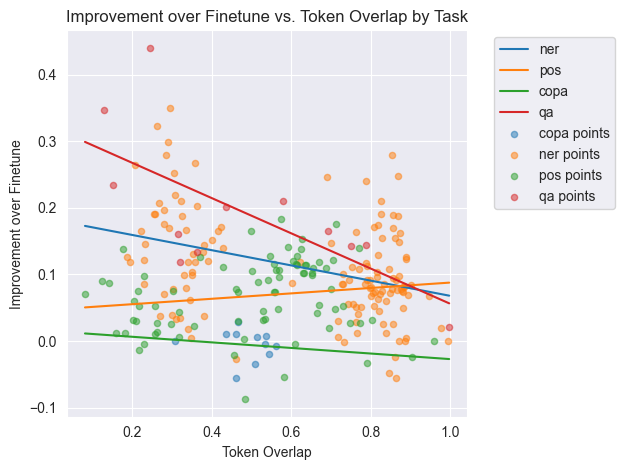

In [23]:
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.formula.api as smf

# 1) Fit the interaction model (no xlm_inclusion)
m2 = smf.ols("finetune_improvement ~ token_overlap * C(task)", data=df).fit()

# 2) Create a grid of token_overlap values
xs = np.linspace(df["token_overlap"].min(), df["token_overlap"].max(), 100)

plt.figure()
for task in df["task"].unique():
    # prepare data for prediction
    df_pred = pd.DataFrame({"token_overlap": xs, "task": task})
    ys = m2.predict(df_pred)
    plt.plot(xs, ys, label=task)

# 3) Scatter the raw data on top
for task, group in df.groupby("task"):
    plt.scatter(group["token_overlap"], group["finetune_improvement"], alpha=0.5, s=20, label=f"{task} points")

plt.xlabel("Token Overlap")
plt.ylabel("Improvement over Finetune")
plt.title("Improvement over Finetune vs. Token Overlap by Task")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

ner
pos


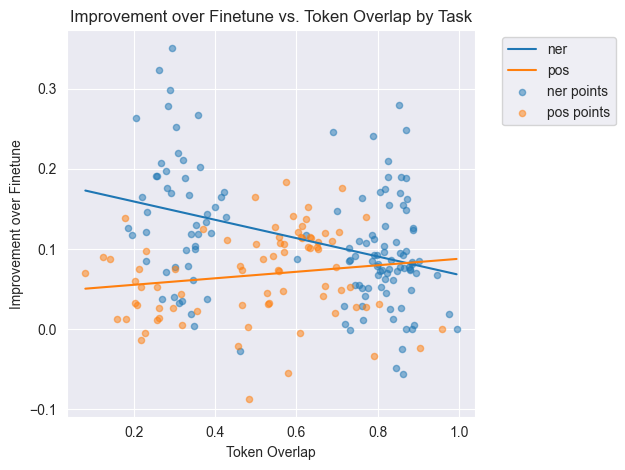

In [24]:
# we now do the same, but only considering languages for which NO adapter exists
# this means dataframe adapter_availability = 0
df_no_adapter = df  # df[df["adapter_availability"] ==1]
df_no_adapter = df_no_adapter[df_no_adapter["task"].isin(["ner", "pos"])]

# 1) Fit the interaction model (no xlm_inclusion)
m2 = smf.ols("finetune_improvement ~ token_overlap * C(task)", data=df_no_adapter).fit()

# 2) Create a grid of token_overlap values
xs = np.linspace(df_no_adapter["token_overlap"].min(), df_no_adapter["token_overlap"].max(), 100)

plt.figure()
for task in df_no_adapter["task"].unique():
    print(task)
    # prepare data for prediction
    df_pred = pd.DataFrame({"token_overlap": xs, "task": task})
    ys = m2.predict(df_pred)
    plt.plot(xs, ys, label=task)

# 3) Scatter the raw data on top
for task, group in df_no_adapter.groupby("task"):
    plt.scatter(group["token_overlap"], group["finetune_improvement"], alpha=0.5, s=20, label=f"{task} points")

plt.xlabel("Token Overlap")
plt.ylabel("Improvement over Finetune")
plt.title("Improvement over Finetune vs. Token Overlap by Task")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

Fun result: for NER, our method gives a higher advantage over finetuning if the token overlap is lower.
For POS, the opposite is true: the higher the token overlap, the better our method performs.

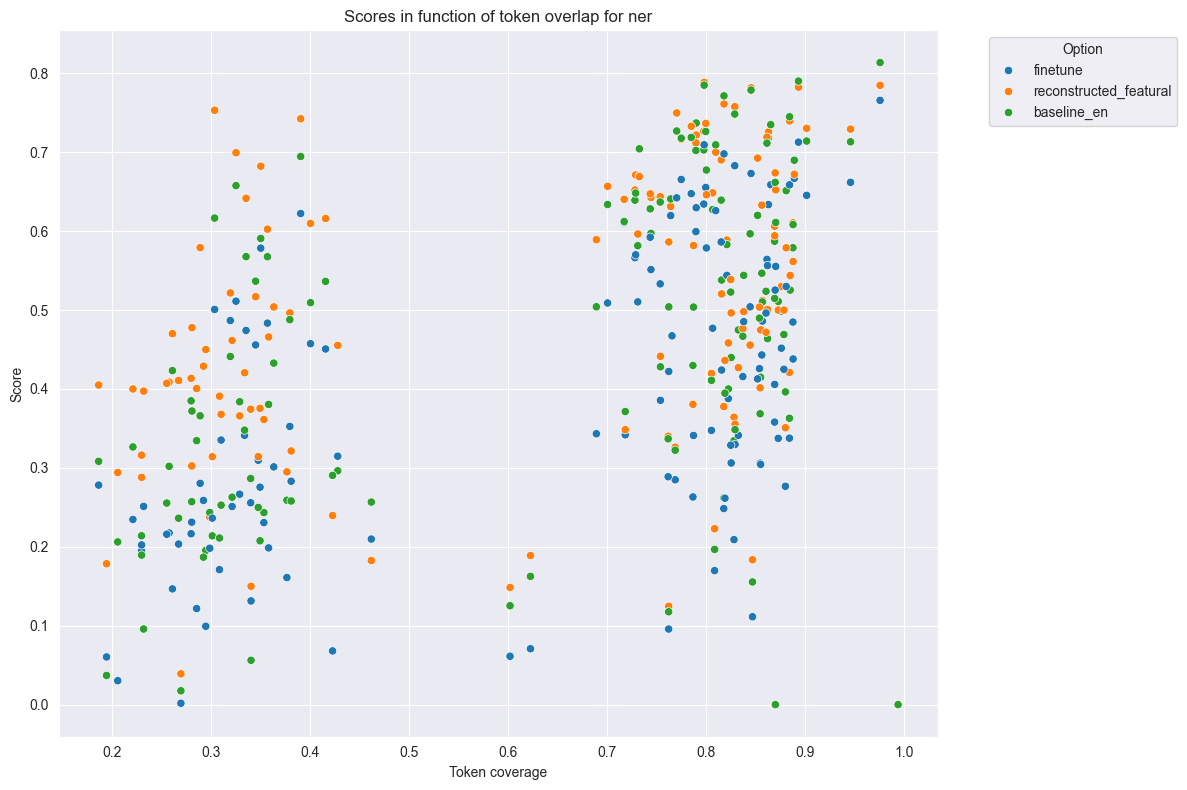

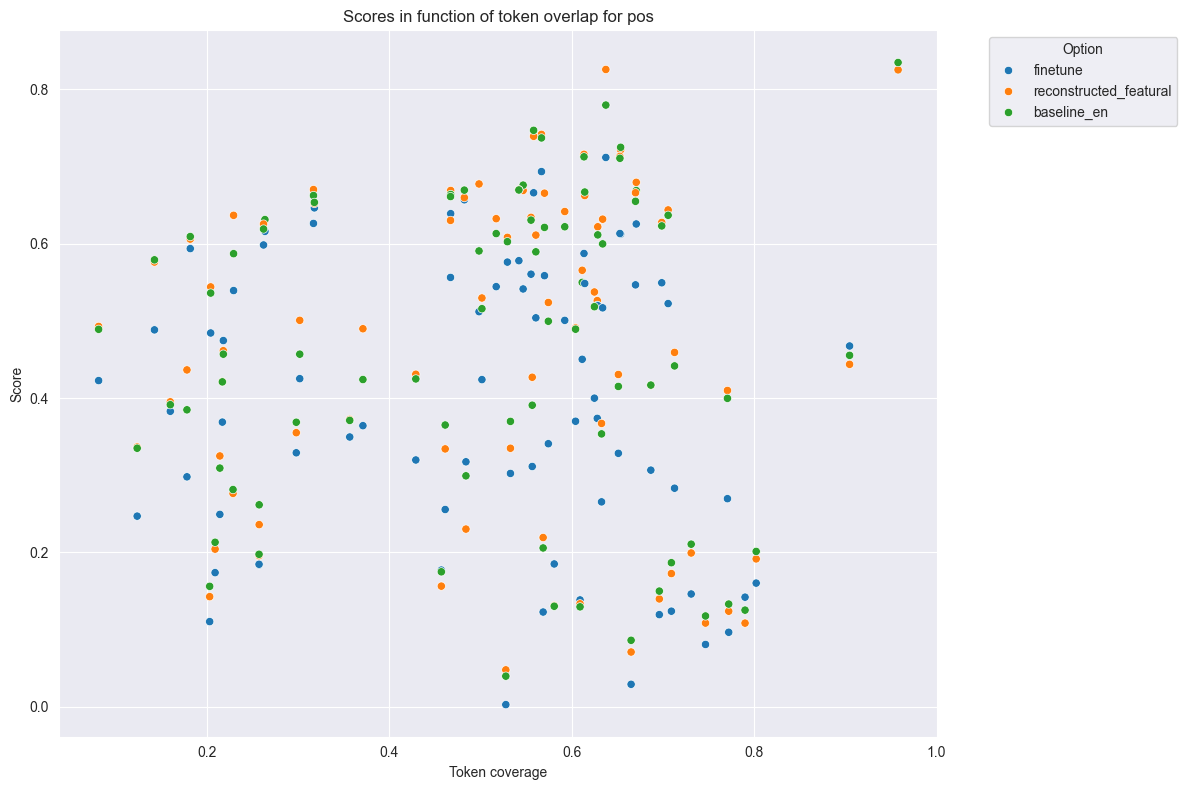

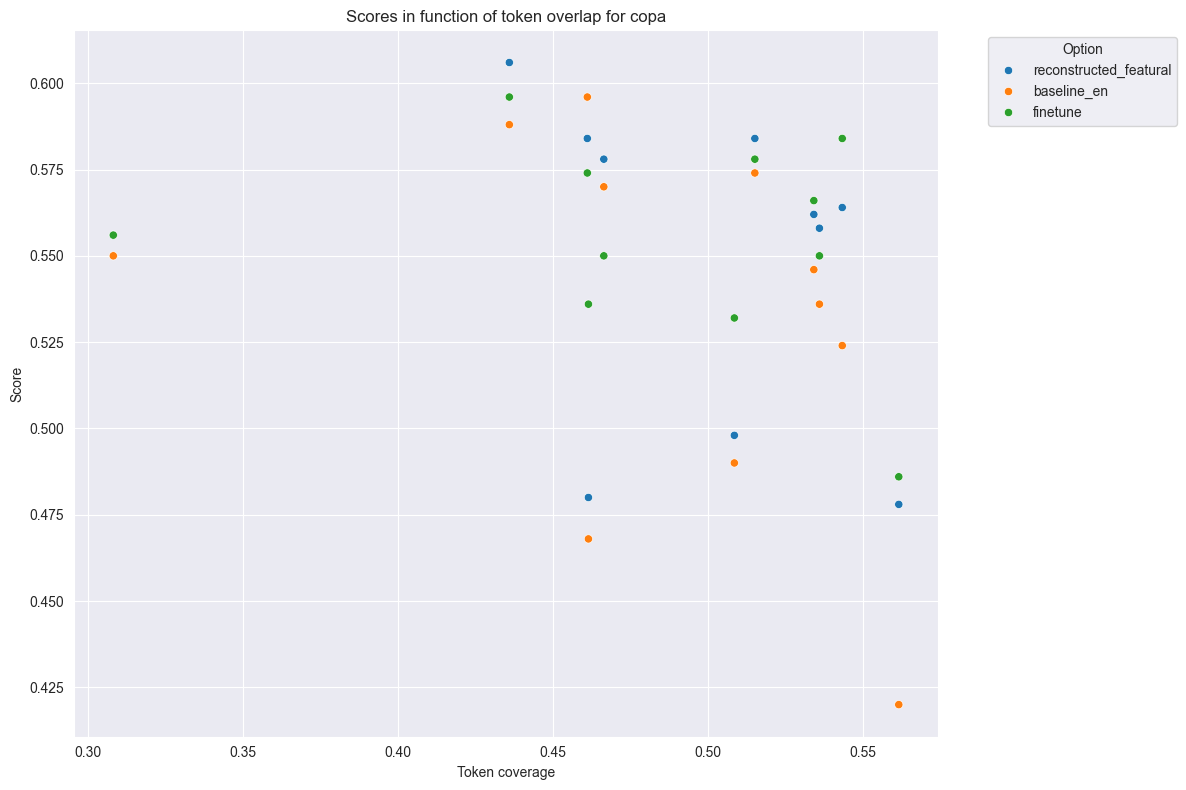

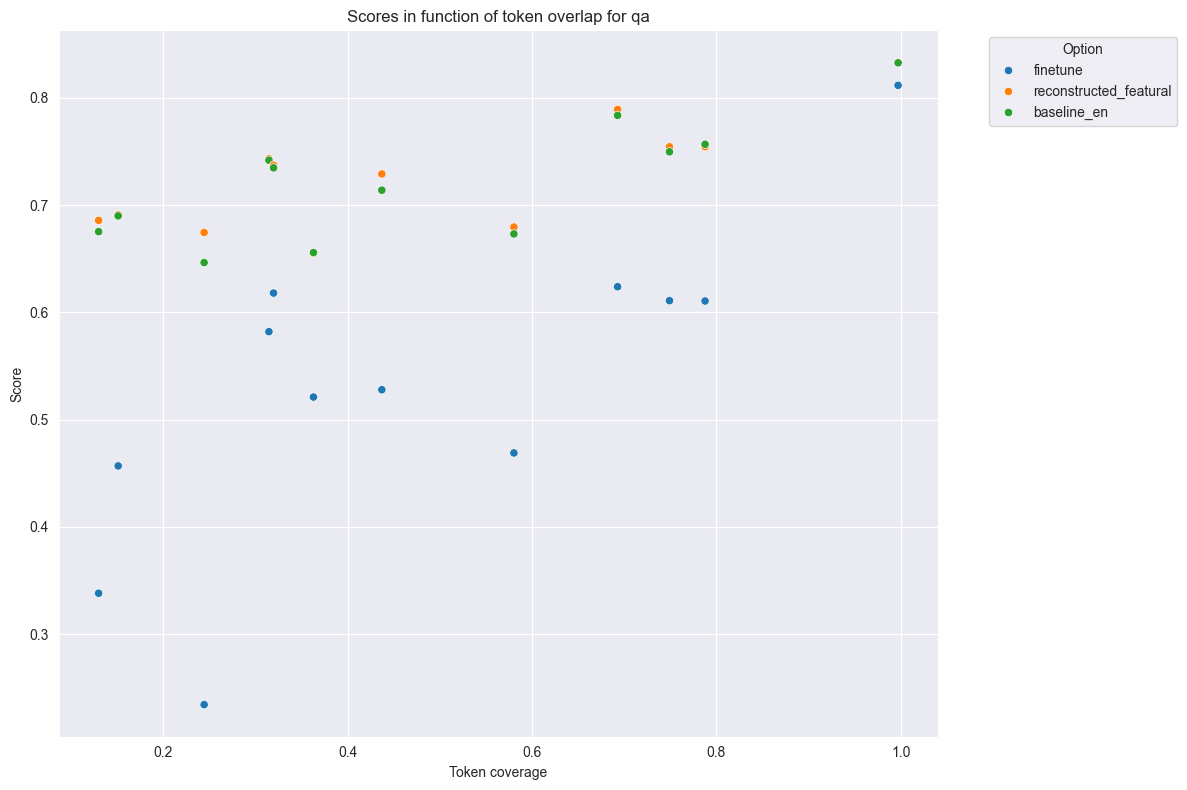

In [62]:
# we plot the scores in function of token overlap
# we create a dataframe with the "reconstructed" scores, the finetune scores and the token overlap

data_overlap = []
for task_name in scores:
    for lang_name in scores[task_name]:
        if lang_name in token_overlap[task_name]:
            for key in scores[task_name][lang_name]:
                data_overlap.append(
                    {
                        "task": task_name,
                        "lang": lang_name,
                        "score": scores[task_name][lang_name][key],
                        "token_coverage": token_overlap[task_name][lang_name]["token_coverage"],
                        "type_overlap": token_overlap[task_name][lang_name]["type_overlap"],
                        "option": key,
                    }
                )
df_overlap = pd.DataFrame(data_overlap)
# we will look at the subset that contains
# baseline_en, no_train_gain, reconstructed_featural
df_subset = df_overlap[df_overlap["option"].isin(["baseline_en", "finetune", "reconstructed_featural"])]

# we plot the scores in function of token overlap
tasks = df_subset["task"].unique()
for task in tasks:
    task_df = df_subset[df_subset["task"] == task]
    plt.figure(figsize=(12, 8))
    sns.scatterplot(data=task_df, x="token_coverage", y="score", hue="option")
    plt.title(f"Scores in function of token overlap for {task}")
    plt.xlabel("Token coverage")
    plt.ylabel("Score")
    plt.legend(title="Option", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

# No train gain analysis


In [26]:
test_column = "reconstructed_featural"
baseline = "no_train_gain"
subsets = {"scores": scores, "no_adapter": no_adapter, "with_adapter": with_adapter}
sign = []
not_sign = []
for name, subset in subsets.items():
    print(f"{test_column} vs {baseline}, {name}")
    t_stat, p_val = get_significance("all", test_column, baseline, alternative="greater", data=subset)
    if p_val < 0.05:
        print("The difference is statistically significant")
        sign.append(name)
    else:
        print("The difference is not statistically significant")
        not_sign.append(name)
    print("-----------------------------------")

print("sign", sign)
print("\nnotsign", not_sign)

reconstructed_featural vs no_train_gain, scores
average scores
reconstructed_featural: 0.5037595015953552
no_train_gain: 0.49921293293449104
t-statistic: 3.0236294299527313
p-value: 0.0013873630267925317
The difference is statistically significant
-----------------------------------
reconstructed_featural vs no_train_gain, no_adapter
average scores
reconstructed_featural: 0.4830920749620409
no_train_gain: 0.47670014455822396
t-statistic: 3.26651499796609
p-value: 0.0006622079134601253
The difference is statistically significant
-----------------------------------
reconstructed_featural vs no_train_gain, scores_subset
average scores
reconstructed_featural: 0.5527708276115005
no_train_gain: 0.552600402512496
t-statistic: 0.08681470836475588
p-value: 0.4655351205788636
The difference is not statistically significant
-----------------------------------
sign ['scores', 'no_adapter']

notsign ['scores_subset']


# Comparison with train_gain
Our method gives a more pronounced boost to the baselines than the no train gain method.
This is significant for the overall scores, and also for the scores of the languages for which no adapter is available.
When an adapter is available (high-resourced languages mostly), the difference is not significant.

In [134]:
test_column = "baseline_closest_featural"
baselines = ["baseline_en"]

sign = []
not_sign = []
for baseline in baselines:
    print(f"ALL tasks, baseline {baseline}")
    t_stat, p_val = get_significance("all", test_column, baseline, alternative="greater", data=with_adapter)
    if p_val < 0.05:
        print("The difference is statistically significant")
        sign.append("all" + "_" + baseline)
    else:
        print("The difference is not statistically significant")
        not_sign.append("all" + "_" + baseline)
    print("-----------------------------------")

print("sign", sign)
print("\nnotsign", not_sign)
# we make a dataframe of the scores
df_madx = pd.DataFrame(
    columns=["task", "lang_name", "baseline_closest_featural", "baseline_en", "distance", "token_overlap"]
)
df_madx["improvement"] = df_madx["baseline_closest_featural"] - df_madx["baseline_en"]

ALL tasks, baseline baseline_en
average scores
baseline_closest_featural: 0.5629223650704409
baseline_en: 0.5348703883097342
t-statistic: 4.485714011655811
p-value: 1.4125339163372235e-05
The difference is statistically significant
-----------------------------------
sign ['all_baseline_en']

notsign []


In [63]:
# we do simple regression. The distance is the independent variable, the score is the dependent variable
# we make sure the columns distance and improvement are arrays
df_madx = df.copy()
df_maxd = df_madx[df_madx["adapter_availability"]]
df_madx = df_madx[df_madx["task"] == "ner"]


X = df_madx[["distance"]]
X = sm.add_constant(X)  # adds the intercept term
y = df_madx["baseline_en_improvement"]
model = sm.OLS(y, X).fit()
print(model.summary())

KeyError: "None of [Index([0, 0, 0, 0, 0, 0, 1, 0, 0, 0,\n       ...\n       1, 1, 1, 1, 0, 1, 1, 1, 1, 1],\n      dtype='int64', length=236)] are in the [columns]"